In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os, gc


In [2]:
train_df = pd.read_csv('store_data/train_df_save4.csv')
test_df  = pd.read_csv('store_data/test_df_save4.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
# info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')

train_df.shape, test_df.shape

((224607, 216), (112392, 215))

## collect dim_changed features

In [3]:
dim_feat_cols = [col for col in train_df.columns if col.startswith('svd') or \
                    col.startswith('pca') or col.startswith('tsne')]
dim_feat_tr = train_df[dim_feat_cols]
dim_feat_ts = test_df[dim_feat_cols]
dim_feat_tr.shape, dim_feat_ts.shape

((224607, 74), (112392, 74))

In [4]:
shap_imp_cols = ['state1_mad','pincode2_mean','emp_code1_get_unique',
    'ltv_round_cat','bureau_score','emp_code1_sum','branch2_min', 'asset_cost', 'ltv',
    'manufac1_min','state1_mad','diff_of_acc','month_of_disbursal','day_of_disbursal',
    'no_of_acc_overdue','pincode2_mean']
train_df[shap_imp_cols].shape, test_df[shap_imp_cols].shape

((224607, 16), (112392, 16))

In [5]:
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,...,pca_4,pca_5,tsne30_1,tsne30_2,tsne60_1,tsne60_2,tsne90_1,tsne90_2,tsne120_1,tsne120_2
0,420825,50578,58400,89.55,67,22807,45,1441,0,6,...,1.215098,0.316675,-13.369084,-13.468479,9.756865,6.885396,-6.599228,-13.856510,12.791006,3.292685
1,537409,47145,65550,73.23,67,22807,45,1502,1,6,...,1.247593,-0.487597,-11.984010,-14.552938,7.462593,1.675558,-9.546783,-13.299788,9.042516,0.833470
2,417566,53278,61360,89.63,67,22807,45,1497,1,6,...,-0.485306,0.811246,12.665901,-12.466926,-7.298840,14.410624,12.964710,2.056213,-6.689389,-0.545910
3,624493,57513,66113,88.48,67,22807,45,1501,1,6,...,0.289948,-0.732252,-1.655971,-1.678139,1.791849,1.949082,-0.193142,-5.974420,2.999097,0.314507
4,539055,52378,60300,88.39,67,22807,45,1495,1,6,...,-0.846238,-0.384123,-0.511550,-0.447596,-6.301483,6.503486,13.990355,0.489619,-1.465677,4.505989


In [6]:
train_df1 = pd.read_csv('train_aox2Jxw/train.csv')
test_df1  = pd.read_csv('test_bqCt9Pv.csv')
train_df1.shape, test_df1.shape

((233154, 41), (112392, 40))

In [7]:
train_df1 = train_df1[['UniqueID','DisbursalDate']]
test_df1 = test_df1[['UniqueID','DisbursalDate']]

train_df = pd.merge(train_df, train_df1, on='UniqueID', how='left')
test_df  = pd.merge(test_df, test_df1, on='UniqueID', how='left')

del train_df1, test_df1
gc.collect()
train_df.shape, test_df.shape

((224607, 217), (112392, 216))

In [8]:
train_df['cv_month'] = train_df.DisbursalDate.apply(lambda x: str(x).split('-')[1])
train_df['cv_date'] = train_df.DisbursalDate.apply(lambda x: str(x).split('-')[0])

test_df['cv_month'] = test_df.DisbursalDate.apply(lambda x: str(x).split('-')[1])
test_df['cv_date'] = test_df.DisbursalDate.apply(lambda x: str(x).split('-')[0])

train_df[['cv_month','cv_date']] = train_df[['cv_month','cv_date']].astype('int')
test_df[['cv_month','cv_date']] = test_df[['cv_month','cv_date']].astype('int')

In [69]:
# train_df[['month_of_disbursal','cv_month']].apply(lambda x: 1 if x[0] == x[1] else 0, axis=1).value_counts()

0    224607
dtype: int64

In [10]:
def run_cat_small(file_path, train_df, target, test_df, test_ids, sub, depth):
    
    splits = 4
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from catboost import Pool, CatBoostClassifier

    features = train_df.columns
    random_seed = 2019
    
    model = CatBoostClassifier(loss_function         = "Logloss", 
                               eval_metric           = "AUC",
                               random_strength       = 1.5,
                               border_count          = 128,
                               scale_pos_weight      = 3.507,
                               depth                 = depth, 
                               early_stopping_rounds = 50,
                               random_seed           = 1337,
                               task_type             = 'CPU', 
    #                            subsample           = 0.7, 
                               iterations            = 10000, 
                               learning_rate         = 0.09,
                               thread_count          = 4
                              )


    n_split = splits
    
    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['cv_month','cv_date']].sort_values(
        by=['cv_month','cv_date'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    test_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    
    y_test_pred = 0

    idx = 0
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid, label=y_valid)#, cat_features=cate_features_index)

    fit_model = model.fit(_train, 
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=100
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, pred)
    print( "  auc = ", score )
    print("="*60)

    y_test_pred = fit_model.predict_proba(test_df)[:,1]


    sub_df = pd.DataFrame({"ID_code":test_ids})
    sub_df["target"] = y_test_pred
    sub_df.columns = sub.columns


    sub_df.to_csv('submission/catboost_{}.csv'.format(file_path), index=None)

    cat_imp = pd.DataFrame(data=[fit_model.feature_names_, 
                                 list(fit_model.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,15))
    plt.barh(cat_imp.feature, cat_imp.imp)
    plt.show()
    
    return score

In [11]:
intersting_cols = ['manufacturer_id','Employment.Type','State_ID','Aadhar_flag','PAN_flag','VoterID_flag',
'Driving_flag','Passport_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.OVERDUE.ACCTS',
'SEC.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
'month_of_birth','credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month',
'day_of_disbursal','month_of_disbursal','Bureau_desc','no_of_loans','no_of_acc','no_of_acc_overdue',
'diff_of_acc','negative_income','income_status','credit_history','loan_tenure','ltv_round_cat',
'no_of_inquiry','state1_max','state1_count','manufac1_max','manufac2_count']

In [12]:
most_imp = ['UniqueID','ltv', 'disbursed_amount', 'year_of_birth','no_of_acc_overdue','month_of_disbursal',
 'Employee_code_ID','Current_pincode_ID','State_ID', 'day_of_disbursal','day_of_birth',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS','no_of_inquiry','PRI.SANCTIONED.AMOUNT','credit_hist_year',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','emp_code1_sum','branch1_max','PRIMARY.INSTAL.AMT',
 'manufacturer_id','manufac1_max', 'cv_month','cv_date']
target = train_df.loan_default
train_df = train_df[list(set(intersting_cols + most_imp + shap_imp_cols))]
test_df  = test_df[list(set(intersting_cols + most_imp + shap_imp_cols))]
train_df.shape, test_df.shape, target.shape

((224607, 56), (112392, 56), (224607,))

In [13]:
test_ids = test_df.UniqueID

0:	test: 0.5896555	best: 0.5896555 (0)	total: 123ms	remaining: 20m 26s
100:	test: 0.6430603	best: 0.6430603 (100)	total: 5.58s	remaining: 9m 7s
200:	test: 0.6499370	best: 0.6499720 (199)	total: 10.9s	remaining: 8m 53s
300:	test: 0.6532084	best: 0.6532084 (300)	total: 16.3s	remaining: 8m 45s
400:	test: 0.6545503	best: 0.6545503 (400)	total: 21.7s	remaining: 8m 40s
500:	test: 0.6556159	best: 0.6556159 (500)	total: 27.1s	remaining: 8m 33s
600:	test: 0.6563087	best: 0.6563087 (600)	total: 32.5s	remaining: 8m 28s
700:	test: 0.6564366	best: 0.6564426 (664)	total: 38.2s	remaining: 8m 26s
800:	test: 0.6569146	best: 0.6569146 (800)	total: 43.9s	remaining: 8m 24s
900:	test: 0.6573647	best: 0.6573647 (900)	total: 50s	remaining: 8m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.657596409
bestIteration = 949

Shrink model to first 950 iterations.
  auc =  0.6575964089709115


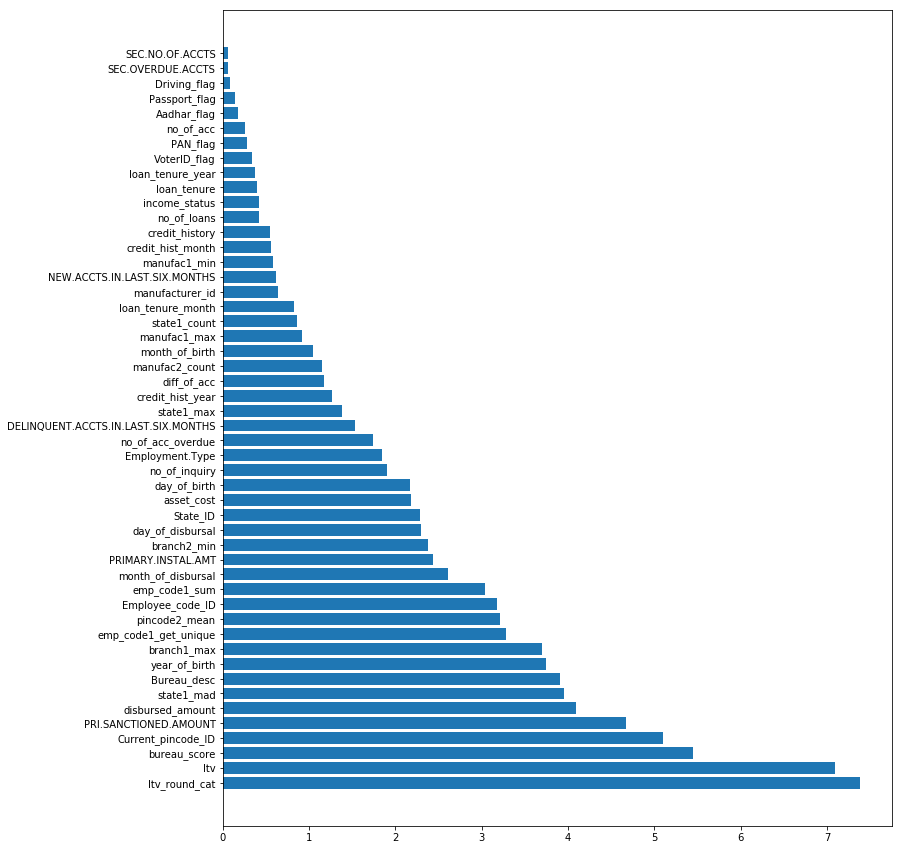

0.6575964089709115

In [16]:
run_cat_small('tuesday_cat1', train_df.drop('UniqueID', axis=1), 
              target, test_df.drop('UniqueID', axis=1), test_ids, sub, 4)


0:	test: 0.5916881	best: 0.5916881 (0)	total: 49.1ms	remaining: 8m 10s
100:	test: 0.6427668	best: 0.6427668 (100)	total: 5.9s	remaining: 9m 38s
200:	test: 0.6502411	best: 0.6502411 (200)	total: 11.7s	remaining: 9m 31s
300:	test: 0.6535282	best: 0.6535484 (295)	total: 18.3s	remaining: 9m 49s
400:	test: 0.6551117	best: 0.6551145 (399)	total: 24.5s	remaining: 9m 46s
500:	test: 0.6565435	best: 0.6565435 (500)	total: 30.2s	remaining: 9m 32s
600:	test: 0.6571935	best: 0.6572131 (598)	total: 35.9s	remaining: 9m 21s
700:	test: 0.6578163	best: 0.6578719 (689)	total: 41.7s	remaining: 9m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6580146411
bestIteration = 732

Shrink model to first 733 iterations.
  auc =  0.6580146411105373


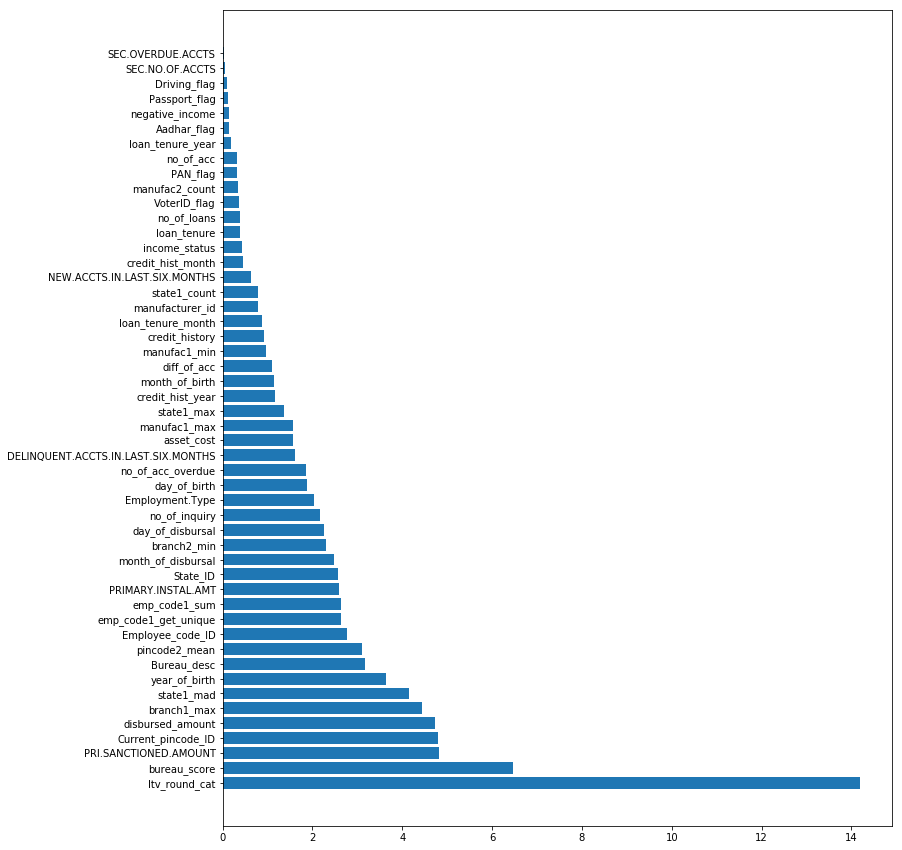

  adding: submission/catboost_tuesday_cat11.csv (deflated 54%)


In [20]:
run_cat_small('tuesday_cat11', train_df.drop(['UniqueID','ltv'], axis=1), 
              target, test_df.drop(['UniqueID','ltv'], axis=1), test_ids, sub, 4)
!zip submission/catboost_tuesday_cat11.zip submission/catboost_tuesday_cat11.csv

0:	test: 0.5957651	best: 0.5957651 (0)	total: 124ms	remaining: 20m 36s
100:	test: 0.6437363	best: 0.6437363 (100)	total: 6.97s	remaining: 11m 23s
200:	test: 0.6513478	best: 0.6513666 (196)	total: 13.8s	remaining: 11m 12s
300:	test: 0.6540720	best: 0.6540720 (300)	total: 20.6s	remaining: 11m 5s
400:	test: 0.6553087	best: 0.6553318 (397)	total: 27.9s	remaining: 11m 8s
500:	test: 0.6561396	best: 0.6561396 (500)	total: 35s	remaining: 11m 4s
600:	test: 0.6569761	best: 0.6569795 (599)	total: 41.9s	remaining: 10m 54s
700:	test: 0.6575104	best: 0.6575104 (700)	total: 48.5s	remaining: 10m 43s
800:	test: 0.6577578	best: 0.6578239 (790)	total: 55.7s	remaining: 10m 39s
900:	test: 0.6583821	best: 0.6583821 (900)	total: 1m 2s	remaining: 10m 32s
1000:	test: 0.6585240	best: 0.6585263 (999)	total: 1m 9s	remaining: 10m 25s
1100:	test: 0.6588881	best: 0.6589114 (1099)	total: 1m 16s	remaining: 10m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6589130791
bestIteration = 1113

Shri

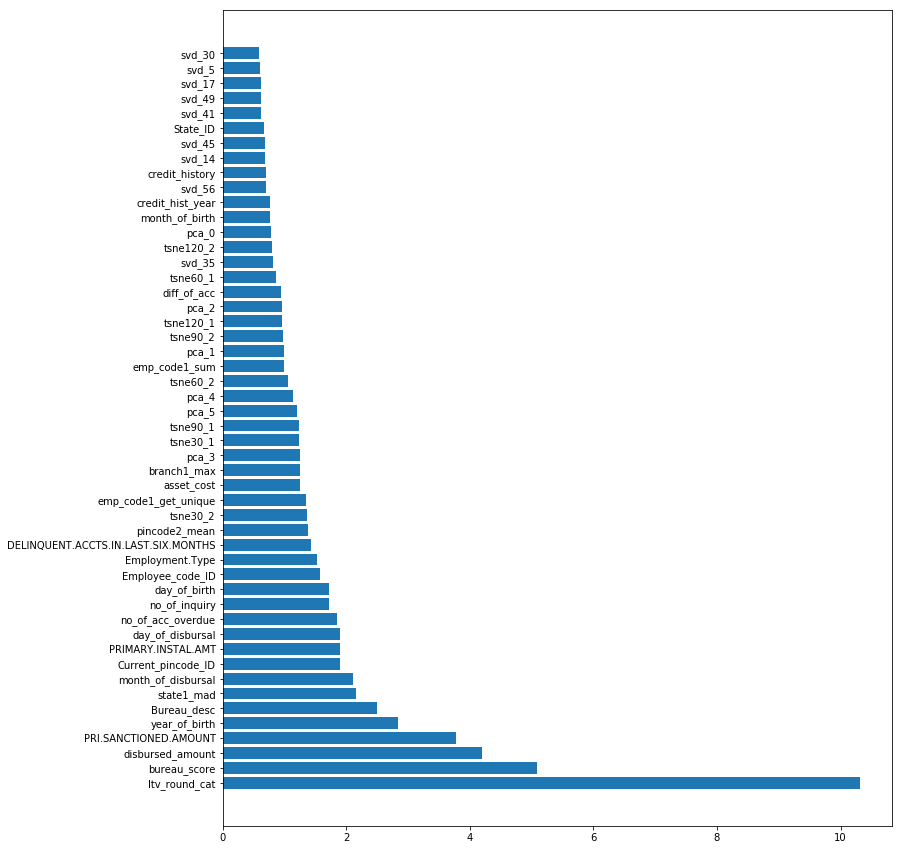

  adding: submission/catboost_tuesday_cat2.csv (deflated 54%)


In [15]:
run_cat_small('tuesday_cat2', 
              pd.concat([train_df.drop(['UniqueID','ltv'], axis=1),dim_feat_tr], axis=1), 
              target, 
              pd.concat([test_df.drop(['UniqueID','ltv'], axis=1),dim_feat_ts], axis=1),
              test_ids, sub, 4)
!zip submission/catboost_tuesday_cat2.zip submission/catboost_tuesday_cat2.csv

0:	test: 0.6009403	best: 0.6009403 (0)	total: 75.3ms	remaining: 12m 32s
100:	test: 0.6490074	best: 0.6490074 (100)	total: 8.23s	remaining: 13m 26s
200:	test: 0.6552549	best: 0.6552786 (199)	total: 16.4s	remaining: 13m 19s
300:	test: 0.6576655	best: 0.6576883 (299)	total: 25.2s	remaining: 13m 32s
400:	test: 0.6584924	best: 0.6585955 (389)	total: 34.3s	remaining: 13m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6592610448
bestIteration = 446

Shrink model to first 447 iterations.
  auc =  0.6592610448052263


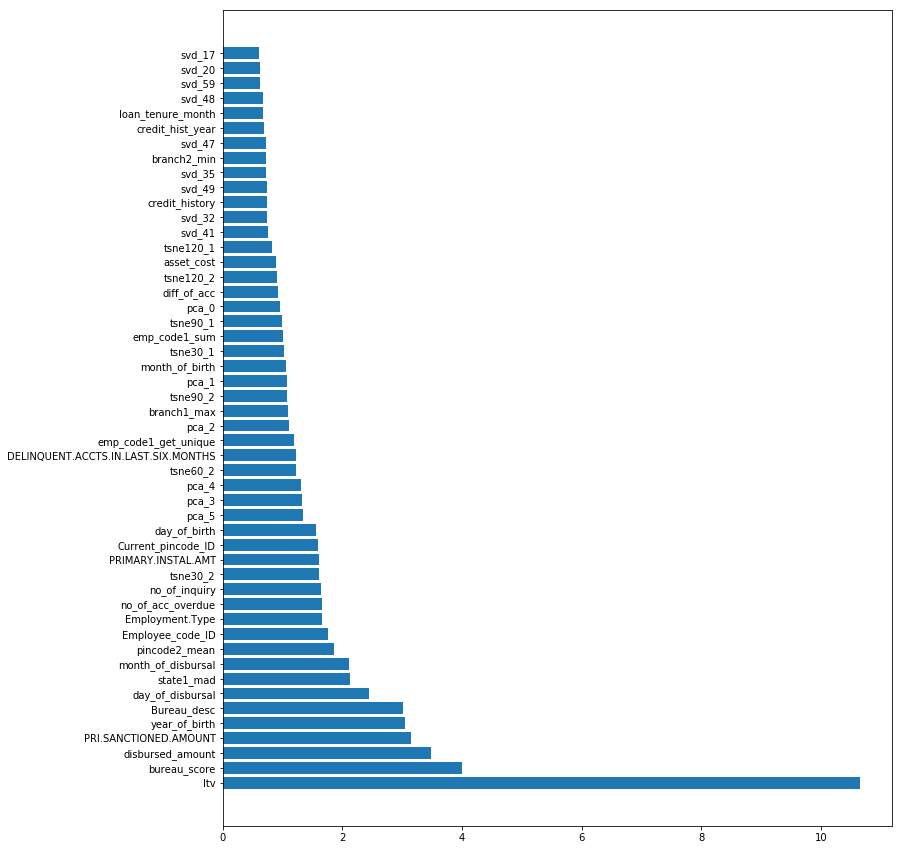

  adding: submission/catboost_tuesday_cat22.csv (deflated 54%)


In [17]:
run_cat_small('tuesday_cat22', 
              pd.concat([train_df.drop(['UniqueID','ltv_round_cat'], axis=1),
                         dim_feat_tr], axis=1), 
              target, 
              pd.concat([test_df.drop(['UniqueID','ltv_round_cat'], axis=1),
                         dim_feat_ts], axis=1),
              test_ids, sub, 6)
!zip submission/catboost_tuesday_cat22.zip submission/catboost_tuesday_cat22.csv

In [14]:
print(train_df.shape, test_df.shape, "==>", end=" ")
train_df = pd.concat([train_df, dim_feat_tr], axis=1)
test_df  = pd.concat([test_df, dim_feat_ts], axis=1)

print(train_df.shape, test_df.shape)

(224607, 56) (112392, 56) ==> (224607, 130) (112392, 130)


In [15]:
import glob
cat_inter_2way = glob.glob('store_data/new_feat/cat_inter_2way/*')
cat_inter_3way = glob.glob('store_data/new_feat/cat_inter_3way_new/*')
int_inter_2way = glob.glob('store_data/new_feat/int_inter_2way/*')
int_inter_3way = glob.glob('store_data/new_feat/int_inter_3way/*')

len(cat_inter_2way), len(cat_inter_3way), len(int_inter_2way), len(int_inter_3way)

(9, 102, 4, 17)

In [16]:
def reduce_mem_usage_wo_print(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    print("="*30)
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    # print(col, "== int8")
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    # print(col, "== int16")
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    # print(col, "== int32")
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    # print(col, "== int64")
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    # print(col, "== float16")
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    # print(col, "== float32")
                else:
                    df[col] = df[col].astype(np.float64)
                    # print(col, "== float64")
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("="*30)
    return

In [17]:
def run_cat_small(file_path, train_df, target, test_df, test_ids, sub, depth):
    
    splits = 4
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from catboost import Pool, CatBoostClassifier

    features = train_df.columns
    random_seed = 2019
    
    model = CatBoostClassifier(loss_function         = "Logloss", 
                               eval_metric           = "AUC",
                               random_strength       = 1.5,
                               border_count          = 128,
                               scale_pos_weight      = 3.507,
                               depth                 = depth, 
                               early_stopping_rounds = 50,
                               random_seed           = 1337,
                               task_type             = 'CPU', 
    #                            subsample           = 0.7, 
                               iterations            = 10000, 
                               learning_rate         = 0.09,
                               thread_count          = 4
                              )


    n_split = splits
    
    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['cv_month','cv_date']].sort_values(
        by=['cv_month','cv_date'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    test_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    
    y_test_pred = 0

    idx = 0
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid, label=y_valid)#, cat_features=cate_features_index)

    fit_model = model.fit(_train, 
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=100
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, pred)
    print( "  auc = ", score )
    print("="*60)

    y_test_pred = fit_model.predict_proba(test_df)[:,1]


    sub_df = pd.DataFrame({"ID_code":test_ids})
    sub_df["target"] = y_test_pred
    sub_df.columns = sub.columns


    sub_df.to_csv('submission/catboost_{}.csv'.format(file_path), index=None)

    cat_imp = pd.DataFrame(data=[fit_model.feature_names_, 
                                 list(fit_model.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    cat_imp = cat_imp.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,15))
    plt.barh(cat_imp.feature, cat_imp.imp)
    plt.show()
    
    return score

In [41]:
def run_rf(train_df, target):
# def run_rf(train_df, target, depth, estimators):
# def run_rf(file_path, train_df, target, test_df, test_ids, sub, depth, estimators):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


    features = train_df.columns

    splits       = 4
    random_seed  = 2019
    n_splits     = splits
    verbose_eval = 200
    early_stop   = 50
    num_rounds   = 10000

    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['cv_month','cv_date']].sort_values(
        by=['cv_month','cv_date'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
#     test_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:] 

    clf = RandomForestClassifier(
                            n_estimators = 200,#estimators, 
                            criterion    = 'gini', 
                            max_depth    = 7, 
                            # min_samples_split = 2, 
                            min_samples_leaf = 3, 
                            # min_weight_fraction_leaf = 0.0, 
                            max_features = 0.7, 
                            bootstrap    = True, 
                            oob_score    = True, 
                            n_jobs       = 4, 
                            random_state = 1337, 
                            verbose      = 1, 
                            class_weight = 'balanced')#3.607)
    clf.fit(X_train, y_train)
#         valid_pred = clf.predict(X_valid)
#         print("CV score: {:<8.5f}".format(roc_auc_score(X_valid, valid_pred)))
        
    valid_pred = clf.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, valid_pred)
    print("CV score: {:<8.5f}".format(score))
#         test_pred = clf.predict()
#         oof_xgb[val_idx]   = valid_pred
    #     predictions   += test_pred


#     print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_xgb)))

#     sub_df = pd.DataFrame({"id":test_ids})
#     sub_df["target"] = test_pred.mean(axis=1)
#     # sub_df.target = np.where(sub_df.target>0.5,1,0)

#     sub_df.columns = sub.columns
#     sub_df.to_csv('submission/xgboost_{}.csv'.format(file_path), index=None)

#     sub_df.head()

    feat_name = train_df.columns
    feat_imp  = clf.feature_importances_

    rf_imp = pd.DataFrame(data=[list(feat_name), list(feat_imp)]).T
    rf_imp.columns=['feature', 'importance']
    rf_imp = rf_imp.sort_values(by='importance', ascending=False).head(25)

    return score, clf, rf_imp

In [42]:
train_df.shape

(224607, 130)

In [43]:
gc.collect()

0

In [44]:
rf_scores = []
rf_models = []
rf_imps   = []

In [45]:
tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)

rf_scores.append(rf_score_)
rf_models.append(rf_model_)
rf_imps.append(rf_imp_)

del tr_data
gc.collect()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63256 


68

In [46]:
cat_inter_2way = glob.glob('store_data/new_feat/cat_inter_2way/*')
print("no of round on interaction: ", len(cat_inter_2way))


for file in cat_inter_2way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')
    reduce_mem_usage_wo_print(cat_feature)
    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    
#     cat_feature_tr = cat_feature.iloc[:train_df.shape[0],:]
#     cat_feature_ts = cat_feature.iloc[train_df.shape[0]:,:]
#     cat_feature_ts.reset_index(drop=True, inplace=True)
    
#     del cat_feature
#     gc.collect()
    
    tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
    tr_data = pd.concat([tr_data, cat_feature], axis=1)
    print(tr_data.shape)
#     ts_data = test_df.drop(['UniqueID','ltv'], axis=1).fillna(0)
    
    del cat_feature
    gc.collect()
    
#     depth = 7
#     estimators = 100
#     rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target, depth, estimators)
    rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)
    
    rf_scores.append(rf_score_)
    rf_models.append(rf_model_)
    rf_imps.append(rf_imp_)
    
    del tr_data
    gc.collect()
    

no of round on interaction:  9
store_data/new_feat/cat_inter_2way/cat_inter_2way_5.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 24.10 MB
Decreased by 86.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63266 
store_data/new_feat/cat_inter_2way/cat_inter_2way_0.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 29.25 MB
Decreased by 83.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63359 
store_data/new_feat/cat_inter_2way/cat_inter_2way_6.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 27.32 MB
Decreased by 84.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63339 
store_data/new_feat/cat_inter_2way/cat_inter_2way_7.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 29.89 MB
Decreased by 83.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63289 
store_data/new_feat/cat_inter_2way/cat_inter_2way_4.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 24.10 MB
Decreased by 86.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63361 
store_data/new_feat/cat_inter_2way/cat_inter_2way_2.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 23.78 MB
Decreased by 86.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63276 
store_data/new_feat/cat_inter_2way/cat_inter_2way_1.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 25.07 MB
Decreased by 86.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63316 
store_data/new_feat/cat_inter_2way/cat_inter_2way_8.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 23.78 MB
Decreased by 86.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63261 
store_data/new_feat/cat_inter_2way/cat_inter_2way_3.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 27.96 MB
Decreased by 84.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63260 


In [47]:
print("shape of list after cat_inter_2way: ",len(rf_scores))


shape of list after cat_inter_2way:  10


In [48]:
int_inter_2way = glob.glob('store_data/new_feat/int_inter_2way/*')
print("no of round on interaction: ", len(int_inter_2way))


for file in int_inter_2way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')
    reduce_mem_usage_wo_print(cat_feature)
    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    
#     cat_feature_tr = cat_feature.iloc[:train_df.shape[0],:]
#     cat_feature_ts = cat_feature.iloc[train_df.shape[0]:,:]
#     cat_feature_ts.reset_index(drop=True, inplace=True)
    
#     del cat_feature
#     gc.collect()
    
    tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
    tr_data = pd.concat([tr_data, cat_feature], axis=1)
    print(tr_data.shape)
#     ts_data = test_df.drop(['UniqueID','ltv'], axis=1).fillna(0)
    
    del cat_feature
    gc.collect()
    
#     0.63425
#     depth = 7
#     estimators = 100
#     rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target, depth, estimators)
    rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)
    
    rf_scores.append(rf_score_)
    rf_models.append(rf_model_)
    rf_imps.append(rf_imp_)
    
    del tr_data
    gc.collect()
    

no of round on interaction:  4
store_data/new_feat/int_inter_2way/num_inter_2way_48.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 58.17 MB
Decreased by 71.7%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63509 
store_data/new_feat/int_inter_2way/num_inter_2way_16.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 57.85 MB
Decreased by 71.9%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   56.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63388 
store_data/new_feat/int_inter_2way/num_inter_2way_64.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 74.88 MB
Decreased by 63.6%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63368 
store_data/new_feat/int_inter_2way/num_inter_2way_32.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 56.89 MB
Decreased by 72.3%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63410 


In [49]:
print("shape of list after num_inter_2way: ",len(rf_scores))


shape of list after num_inter_2way:  14


In [50]:
int_inter_3way = glob.glob('store_data/new_feat/int_inter_3way/*')
print("no of round on interaction: ", len(int_inter_3way))


for file in int_inter_3way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')
    reduce_mem_usage_wo_print(cat_feature)
    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    
#     cat_feature_tr = cat_feature.iloc[:train_df.shape[0],:]
#     cat_feature_ts = cat_feature.iloc[train_df.shape[0]:,:]
#     cat_feature_ts.reset_index(drop=True, inplace=True)
    
#     del cat_feature
#     gc.collect()
    
    tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
    tr_data = pd.concat([tr_data, cat_feature], axis=1)
    print(tr_data.shape)
#     ts_data = test_df.drop(['UniqueID','ltv'], axis=1).fillna(0)
    
    del cat_feature
    gc.collect()
    
#     depth = 7
#     estimators = 100
#     rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target, depth, estimators)
    rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)
    
    rf_scores.append(rf_score_)
    rf_models.append(rf_model_)
    rf_imps.append(rf_imp_)
    
    del tr_data
    gc.collect()
    

no of round on interaction:  17
store_data/new_feat/int_inter_3way/num_inter_3way_16.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 64.28 MB
Decreased by 68.7%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63418 
store_data/new_feat/int_inter_3way/num_inter_3way_112.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 66.85 MB
Decreased by 67.5%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63444 
store_data/new_feat/int_inter_3way/num_inter_3way_64.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 60.10 MB
Decreased by 70.8%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63519 
store_data/new_feat/int_inter_3way/num_inter_3way_144.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 77.13 MB
Decreased by 62.5%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63294 
store_data/new_feat/int_inter_3way/num_inter_3way_32.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 68.13 MB
Decreased by 66.9%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63468 
store_data/new_feat/int_inter_3way/num_inter_3way_208.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 66.21 MB
Decreased by 67.8%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63491 
store_data/new_feat/int_inter_3way/num_inter_3way_48.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 80.67 MB
Decreased by 60.8%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63582 
store_data/new_feat/int_inter_3way/num_inter_3way_240.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 75.53 MB
Decreased by 63.3%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63450 
store_data/new_feat/int_inter_3way/num_inter_3way_128.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 57.21 MB
Decreased by 72.2%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63359 
store_data/new_feat/int_inter_3way/num_inter_3way_176.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 63.63 MB
Decreased by 69.1%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63402 
store_data/new_feat/int_inter_3way/num_inter_3way_96.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 58.81 MB
Decreased by 71.4%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   57.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63467 
store_data/new_feat/int_inter_3way/num_inter_3way_192.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 73.28 MB
Decreased by 64.4%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63469 
store_data/new_feat/int_inter_3way/num_inter_3way_272.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 69.42 MB
Decreased by 66.2%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63509 
store_data/new_feat/int_inter_3way/num_inter_3way_160.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 75.85 MB
Decreased by 63.1%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63304 
store_data/new_feat/int_inter_3way/num_inter_3way_80.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 60.42 MB
Decreased by 70.6%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63326 
store_data/new_feat/int_inter_3way/num_inter_3way_224.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 64.28 MB
Decreased by 68.7%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   57.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63510 
store_data/new_feat/int_inter_3way/num_inter_3way_256.csv
Memory usage of dataframe is 205.69 MB
Memory usage after optimization is: 93.20 MB
Decreased by 54.7%
(224607, 208)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63419 


In [51]:
print("shape of list after num_inter_3way: ",len(rf_scores))


shape of list after num_inter_3way:  31


In [52]:
cat_inter_3way = glob.glob('store_data/new_feat/cat_inter_3way_new/*')
print("no of round on interaction: ", len(cat_inter_3way))


for file in cat_inter_3way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')
    reduce_mem_usage_wo_print(cat_feature)
    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    
#     cat_feature_tr = cat_feature.iloc[:train_df.shape[0],:]
#     cat_feature_ts = cat_feature.iloc[train_df.shape[0]:,:]
#     cat_feature_ts.reset_index(drop=True, inplace=True)
    
#     del cat_feature
#     gc.collect()
    
    tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
    tr_data = pd.concat([tr_data, cat_feature], axis=1)
    print(tr_data.shape)
#     ts_data = test_df.drop(['UniqueID','ltv'], axis=1).fillna(0)
    
    del cat_feature
    gc.collect()
    
#     depth = 6
#     estimators = 100
#     rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target, depth, estimators)
    rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)
    
    rf_scores.append(rf_score_)
    rf_models.append(rf_model_)
    rf_imps.append(rf_imp_)
    
    del tr_data
    gc.collect()
    

no of round on interaction:  102
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_7.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.96 MB
Decreased by 79.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63317 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_38.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 30.53 MB
Decreased by 83.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63344 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_96.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.25 MB
Decreased by 78.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63358 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_67.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.10 MB
Decreased by 81.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63349 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_42.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.89 MB
Decreased by 78.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63302 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_39.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63313 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_16.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63317 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_46.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.60 MB
Decreased by 79.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63277 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_78.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 30.21 MB
Decreased by 83.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63384 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_21.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.32 MB
Decreased by 79.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63388 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_9.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 30.21 MB
Decreased by 83.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63272 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_82.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.46 MB
Decreased by 82.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63325 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_90.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.00 MB
Decreased by 80.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63304 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_18.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 42.42 MB
Decreased by 76.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63321 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_95.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 31.17 MB
Decreased by 82.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63295 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_60.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.71 MB
Decreased by 80.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63266 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_92.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.96 MB
Decreased by 79.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63282 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_80.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.89 MB
Decreased by 78.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63359 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_69.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.49 MB
Decreased by 77.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63286 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_66.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.14 MB
Decreased by 82.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63321 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_48.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.64 MB
Decreased by 79.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63248 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_41.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63293 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_54.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.46 MB
Decreased by 82.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63368 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_71.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 28.28 MB
Decreased by 84.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63267 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_63.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63268 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_51.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63296 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_40.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.14 MB
Decreased by 82.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63269 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_26.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 30.85 MB
Decreased by 82.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63370 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_14.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63288 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_75.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 39.21 MB
Decreased by 78.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   53.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63283 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_43.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63298 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_15.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 42.42 MB
Decreased by 76.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63213 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_88.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 41.46 MB
Decreased by 77.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63257 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_98.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63369 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_49.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63328 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_6.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63297 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_94.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.28 MB
Decreased by 79.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63265 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_100.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 31.50 MB
Decreased by 82.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63294 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_87.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63275 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_27.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.14 MB
Decreased by 82.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63273 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_55.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.42 MB
Decreased by 81.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63318 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_28.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 28.60 MB
Decreased by 84.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63270 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_5.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.10 MB
Decreased by 81.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63303 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_2.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.25 MB
Decreased by 78.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63331 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_77.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 39.85 MB
Decreased by 77.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63290 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_0.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.10 MB
Decreased by 81.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63329 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_57.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.67 MB
Decreased by 80.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63298 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_3.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.57 MB
Decreased by 78.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63432 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_99.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63307 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_97.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.75 MB
Decreased by 81.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63299 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_85.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63296 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_22.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63264 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_45.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.00 MB
Decreased by 80.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63344 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_34.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.42 MB
Decreased by 81.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63263 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_101.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.10 MB
Decreased by 81.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63311 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_1.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.28 MB
Decreased by 79.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63304 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_86.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.78 MB
Decreased by 81.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63345 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_33.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63305 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_91.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63295 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_25.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63253 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_65.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.07 MB
Decreased by 81.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63275 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_17.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.00 MB
Decreased by 80.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63314 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_64.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.75 MB
Decreased by 81.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63321 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_93.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.28 MB
Decreased by 79.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63328 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_4.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.67 MB
Decreased by 80.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63241 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_83.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.07 MB
Decreased by 81.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63222 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_47.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.14 MB
Decreased by 82.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63246 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_36.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.67 MB
Decreased by 80.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63350 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_10.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.96 MB
Decreased by 79.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63341 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_44.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 39.21 MB
Decreased by 78.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63265 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_37.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 41.46 MB
Decreased by 77.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63245 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_19.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.60 MB
Decreased by 79.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63295 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_12.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63322 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_13.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.42 MB
Decreased by 81.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63376 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_58.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 28.28 MB
Decreased by 84.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63262 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_35.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 39.85 MB
Decreased by 77.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63302 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_24.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.75 MB
Decreased by 81.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63287 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_81.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.71 MB
Decreased by 80.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63289 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_76.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.96 MB
Decreased by 79.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63261 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_23.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.46 MB
Decreased by 82.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63293 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_62.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63284 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_56.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63319 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_89.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.89 MB
Decreased by 78.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63266 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_79.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 41.46 MB
Decreased by 77.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63332 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_84.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.07 MB
Decreased by 81.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63330 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_31.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 30.21 MB
Decreased by 83.2%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished


CV score: 0.63231 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_72.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.71 MB
Decreased by 80.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63331 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_50.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 31.50 MB
Decreased by 82.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63306 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_70.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 35.03 MB
Decreased by 80.5%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63280 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_73.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63266 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_11.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.00 MB
Decreased by 80.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63312 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_29.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 40.17 MB
Decreased by 77.7%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63270 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_74.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.32 MB
Decreased by 79.8%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63272 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_20.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.07 MB
Decreased by 81.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63272 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_30.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 32.46 MB
Decreased by 82.0%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63314 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_8.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 28.28 MB
Decreased by 84.3%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63354 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_59.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 36.64 MB
Decreased by 79.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63333 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_61.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.07 MB
Decreased by 81.1%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63339 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_32.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 38.57 MB
Decreased by 78.6%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63278 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_68.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 33.42 MB
Decreased by 81.4%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63279 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_52.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 37.92 MB
Decreased by 78.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63309 
store_data/new_feat/cat_inter_3way_new/cat_inter_3way_53.csv
Memory usage of dataframe is 179.98 MB
Memory usage after optimization is: 34.39 MB
Decreased by 80.9%
(224607, 198)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


CV score: 0.63300 


In [53]:
print("shape of list after cat_inter_3way: ",len(rf_scores))


shape of list after cat_inter_3way:  133


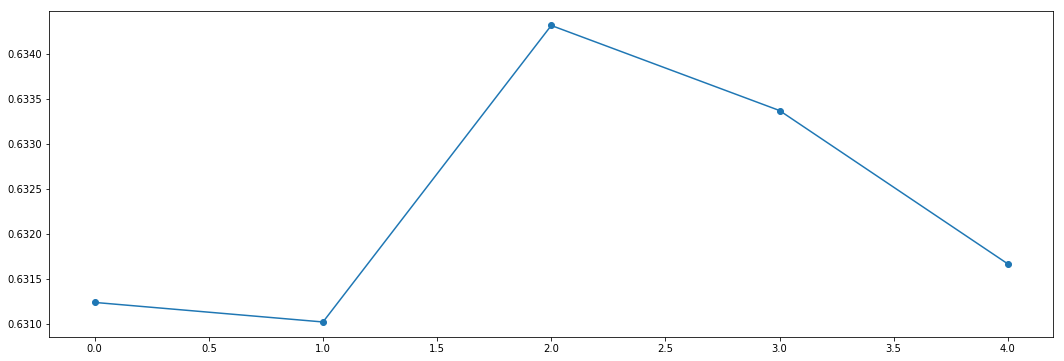

In [40]:
plt.figure(figsize=(18,6))
plt.plot(rf_scores,'-o')

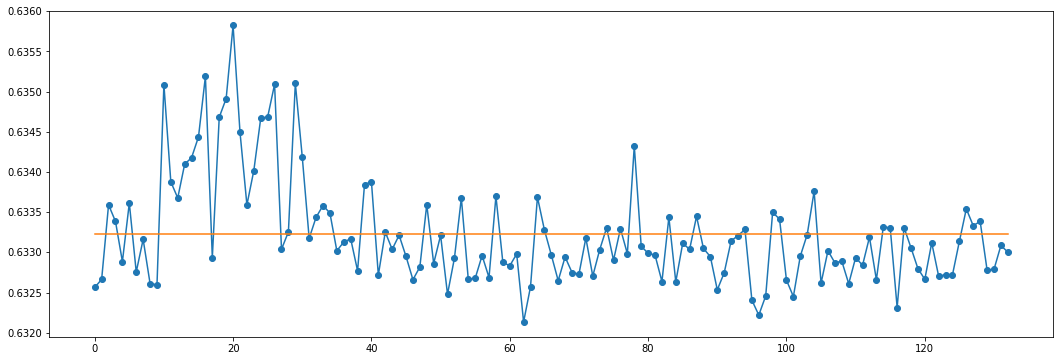

In [60]:
plt.figure(figsize=(18,6))
plt.plot(rf_scores,'-o')
plt.plot(np.arange(len(rf_scores)), np.ones(len(rf_scores))*np.mean(rf_scores))

In [61]:
rf_imps

[                                 feature  importance
 11                                   ltv    0.232249
 22                          bureau_score    0.136226
 14                            state1_mad   0.0627786
 5                       disbursed_amount   0.0594687
 29                 PRI.SANCTIONED.AMOUNT   0.0549901
 9                            Bureau_desc   0.0368062
 25                         no_of_inquiry   0.0305639
 8                     Current_pincode_ID   0.0256667
 77                                svd_25   0.0205764
 66                                svd_14   0.0139438
 33                         year_of_birth   0.0116589
 108                               svd_56   0.0101154
 38                       Employment.Type  0.00995216
 23                    PRIMARY.INSTAL.AMT   0.0095428
 44                     no_of_acc_overdue  0.00928197
 78                                svd_26  0.00881381
 114                                pca_2  0.00879525
 50   DELINQUENT.ACCTS.IN.LA

In [63]:
import re

def split_it(x):
    return re.findall('[:\+\-\*\/]', x)# 


save_feat = pd.DataFrame()
for ii,imp in enumerate(rf_imps):
    imp['position'] = np.arange(imp.shape[0])+1
    imp['position'] = imp.apply(lambda x: x[2] if split_it(x[0]) else 0, axis=1)
    imp['which_file'] = ii
    save_feat = pd.concat([save_feat, imp[imp.position != 0]], axis=0)
    
    if ii%10 == 0:
        print("reach here at ",ii)

reach here at  0
reach here at  10
reach here at  20
reach here at  30
reach here at  40
reach here at  50
reach here at  60
reach here at  70
reach here at  80
reach here at  90
reach here at  100
reach here at  110
reach here at  120
reach here at  130


In [70]:
save_feat[save_feat.importance > 0.1]

,feature,importance,position,which_file
188,ltv*disbursed_amt,0.168704,1,10
198,assest*ltv,0.18208,1,11
166,pri_sanc+bureau_score,0.145099,2,11
126,ltv+emp_code1_unique,0.15679,1,12
161,pri_sanc+assest+bureau_score,0.159054,2,14
196,pri_sanc+bureau_score+pincode2_mean,0.128035,2,16
176,pri_sanc+emp_code1_sum+bureau_score,0.145364,2,18
136,pri_sanc+ltv+bureau_score,0.141442,2,20
151,ltv+emp_code1_unique+pincode2_mean,0.141337,1,21
166,emp_code1_sum+ltv+disbursed_amt,0.12777,2,23


In [66]:
save_feat[save_feat.position < 5]

,feature,importance,position,which_file
188,ltv*disbursed_amt,0.168704,1,10
157,emp_code1_sum-bureau_score,0.0638292,2,10
197,ltv-bureau_score,0.0577303,3,10
198,assest*ltv,0.18208,1,11
166,pri_sanc+bureau_score,0.145099,2,11
126,ltv+emp_code1_unique,0.15679,1,12
143,assest*bureau_score,0.066789,2,13
135,assest/disbursed_amt_post,0.0612579,3,13
161,pri_sanc+assest+bureau_score,0.159054,2,14
196,pri_sanc+bureau_score+pincode2_mean,0.128035,2,16


In [69]:
save_feat[(save_feat.position > 5) | (save_feat.position < 10) | 
          (save_feat.importance > 0.0999)]

,feature,importance,position,which_file
145,PAN_flag:ltv_round_cat,0.0127846,10,1
158,no_of_acc_overdue:ltv_round_cat,0.0248267,8,2
159,no_of_acc_overdue:no_of_inquiry,0.014878,11,2
162,no_of_acc_overdue:manufac1_max,0.0107661,14,2
161,no_of_acc_overdue:state1_count,0.00819589,18,2
190,Employment.Type:ltv_round_cat,0.0140357,10,3
156,credit_history:ltv_round_cat,0.00796874,16,3
160,credit_history:manufac1_max,0.005441,25,3
152,income_status:credit_history,0.00869885,16,4
154,income_status:ltv_round_cat,0.007103,23,4


In [71]:
save_feat.to_csv('store_data/interaction_feature_importance2.csv', index=None)
np.save('store_data/intraction_feature_rf_scores2.npy', rf_scores)

In [72]:
int_inter_2way = glob.glob('store_data/new_feat/int_inter_2way/*')
print("no of round on interaction: ", len(int_inter_2way))

feat_test = pd.DataFrame()
for file in int_inter_2way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    reduce_mem_usage_wo_print(cat_feature)

    feat_test = pd.concat([feat_test, cat_feature], axis=1)

    del cat_feature
    gc.collect()


no of round on interaction:  4
store_data/new_feat/int_inter_2way/num_inter_2way_48.csv
Memory usage of dataframe is 137.09 MB
Memory usage after optimization is: 37.06 MB
Decreased by 73.0%
store_data/new_feat/int_inter_2way/num_inter_2way_16.csv
Memory usage of dataframe is 137.09 MB
Memory usage after optimization is: 37.27 MB
Decreased by 72.8%
store_data/new_feat/int_inter_2way/num_inter_2way_64.csv
Memory usage of dataframe is 137.09 MB
Memory usage after optimization is: 41.56 MB
Decreased by 69.7%
store_data/new_feat/int_inter_2way/num_inter_2way_32.csv
Memory usage of dataframe is 137.09 MB
Memory usage after optimization is: 35.13 MB
Decreased by 74.4%


In [73]:
feat_test.shape

(224607, 320)

In [74]:
feat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224607 entries, 0 to 224606
Columns: 320 entries, pincode+pincode2_mean to pincode/emp_code1_unique_post
dtypes: int16(151), int32(78), int8(91)
memory usage: 151.0 MB


In [77]:
count_gps = feat_test.apply(lambda x: pd.Series(x).value_counts().shape[0])
count_gps[count_gps.values == 1]

emp_code1_sum/branch2_min_pre          1
emp_code1_sum/disbursed_amt_pre        1
emp_code1_sum/birth_year_pre           1
emp_code1_sum/branch1_max_pre          1
emp_code1_sum/emp_code1_unique_post    1
ltv/branch2_min_pre                    1
ltv/disbursed_amt_pre                  1
ltv/birth_year_pre                     1
ltv/branch1_max_pre                    1
pri_sanc/branch2_min_pre               1
pri_sanc/birth_year_pre                1
ltv/pincode2_mean_post                 1
branch2_min/disbursed_amt_post         1
branch2_min/birth_year_post            1
branch2_min/bureau_score_post          1
branch2_min/branch1_max_post           1
branch2_min/emp_code1_unique_post      1
branch2_min/pincode2_mean_post         1
disbursed_amt/birth_year_pre           1
assest/branch2_min_pre                 1
assest/disbursed_amt_pre               1
assest/birth_year_pre                  1
assest/branch1_max_pre                 1
assest/pincode2_mean_post              1
pincode/branch2_

In [78]:
feat_test.drop(list(count_gps[count_gps.values == 1].index), axis=1, inplace=True)

In [87]:
def run_rf(train_df, target):
# def run_rf(train_df, target, depth, estimators):
# def run_rf(file_path, train_df, target, test_df, test_ids, sub, depth, estimators):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


    features = train_df.columns

    splits       = 4
    random_seed  = 2019
    n_splits     = splits
    verbose_eval = 200
    early_stop   = 50
    num_rounds   = 10000

    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['cv_month','cv_date']].sort_values(
        by=['cv_month','cv_date'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
#     test_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:] 

    clf = RandomForestClassifier(
                            n_estimators = 200,#estimators, 
                            criterion    = 'gini', 
#                             max_depth    = 7, 
                            # min_samples_split = 2, 
                            min_samples_leaf = 3, 
                            # min_weight_fraction_leaf = 0.0, 
                            max_features = 0.7, 
                            bootstrap    = True, 
                            oob_score    = True, 
                            n_jobs       = 4, 
                            random_state = 1337, 
                            verbose      = 1, 
                            class_weight = 'balanced')#3.607)
    clf.fit(X_train, y_train)
#         valid_pred = clf.predict(X_valid)
#         print("CV score: {:<8.5f}".format(roc_auc_score(X_valid, valid_pred)))
        
    valid_pred = clf.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, valid_pred)
    print("CV score: {:<8.5f}".format(score))
#         test_pred = clf.predict()
#         oof_xgb[val_idx]   = valid_pred
    #     predictions   += test_pred


#     print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_xgb)))

#     sub_df = pd.DataFrame({"id":test_ids})
#     sub_df["target"] = test_pred.mean(axis=1)
#     # sub_df.target = np.where(sub_df.target>0.5,1,0)

#     sub_df.columns = sub.columns
#     sub_df.to_csv('submission/xgboost_{}.csv'.format(file_path), index=None)

#     sub_df.head()

    feat_name = train_df.columns
    feat_imp  = clf.feature_importances_

    rf_imp = pd.DataFrame(data=[list(feat_name), list(feat_imp)]).T
    rf_imp.columns=['feature', 'importance']
    rf_imp = rf_imp.sort_values(by='importance', ascending=False)#.head(25)

    return score, clf, rf_imp

In [88]:
tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
tr_data = pd.concat([tr_data, feat_test], axis=1)
print(tr_data.shape)

# del cat_feature
gc.collect()


rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)

del tr_data
gc.collect()

(224607, 423)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 29.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 30.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


CV score: 0.63178 


33

In [89]:
rf_imp_111 = rf_imp_

In [94]:
tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
tr_data = pd.concat([tr_data, feat_test], axis=1)
print(tr_data.shape)

tr_data = tr_data[list(rf_imp_.head(64).feature.values) + ['cv_month', 'cv_date']]
print(tr_data.shape)


# del cat_feature
gc.collect()


rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)
del tr_data
gc.collect()

rf_imp_

(224607, 423)
(224607, 66)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


CV score: 0.62392 


,feature,importance
4,pri_sanc+bureau_score,0.0319089
0,ltv*disbursed_amt,0.0306803
1,pca_5,0.022689
3,tsne60_2,0.0224855
2,tsne60_1,0.0223411
7,pca_4,0.0221164
5,tsne90_2,0.0217845
15,Employee_code_ID,0.0217435
6,tsne90_1,0.0211834
8,tsne30_1,0.0210597


In [103]:
rf_imp_111[rf_imp_111.importance < 1e-3].apply(lambda x: " " if split_it(x[0]) else x[0], axis=1)

300                                
309                                
285                                
192                                
27     NEW.ACCTS.IN.LAST.SIX.MONTHS
41                      branch1_max
301                                
211                                
239                                
13                      loan_tenure
360                                
160                                
19                     VoterID_flag
394                                
261                                
216                                
172                                
157                                
43                      Aadhar_flag
44                no_of_acc_overdue
137                                
302                                
368                                
248                                
351                                
218                                
333                                
278                         

In [104]:
feat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224607 entries, 0 to 224606
Columns: 295 entries, pincode+pincode2_mean to pincode/emp_code1_unique_post
dtypes: int16(151), int32(78), int8(66)
memory usage: 145.7 MB


In [115]:
tr_data = train_df.drop(['UniqueID','ltv_round_cat'], axis=1).fillna(0)
tr_data = pd.concat([tr_data, feat_test], axis=1)
print(tr_data.shape)

# tr_data = tr_data[list(rf_imp_.head(64).feature.values) + ['cv_month', 'cv_date']]
# print(tr_data.shape)


(224607, 423)


In [116]:
tr_data[rf_imp_111[rf_imp_111.importance < 1e-3].feature.values].shape, tr_data.shape

((224607, 170), (224607, 423))

In [117]:
tr_data = tr_data[rf_imp_111[rf_imp_111.importance < 1e-3].feature.values]
tr_data.shape

(224607, 170)

In [105]:
cat_inter_2way = glob.glob('store_data/new_feat/cat_inter_2way/*')
print("no of round on interaction: ", len(cat_inter_2way))

feat_test1 = pd.DataFrame()
for file in cat_inter_2way:
    print(file)
    cat_feature = pd.read_csv(file)
    cat_feature = cat_feature.astype('int')    
    cat_feature = cat_feature.iloc[:train_df.shape[0],:]
    reduce_mem_usage_wo_print(cat_feature)

    feat_test1 = pd.concat([feat_test1, cat_feature], axis=1)

    del cat_feature
    gc.collect()


no of round on interaction:  9
store_data/new_feat/cat_inter_2way/cat_inter_2way_5.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 16.07 MB
Decreased by 86.6%
store_data/new_feat/cat_inter_2way/cat_inter_2way_0.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 19.49 MB
Decreased by 83.7%
store_data/new_feat/cat_inter_2way/cat_inter_2way_6.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 18.21 MB
Decreased by 84.8%
store_data/new_feat/cat_inter_2way/cat_inter_2way_7.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 19.28 MB
Decreased by 83.9%
store_data/new_feat/cat_inter_2way/cat_inter_2way_4.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 16.07 MB
Decreased by 86.6%
store_data/new_feat/cat_inter_2way/cat_inter_2way_2.csv
Memory usage of dataframe is 119.95 MB
Memory usage after optimization is: 15.85 MB
Decreased by 86.8%
store_data/new_

In [124]:
# feat_test1.iloc[:,:3].T.drop_duplicates(keep=False)

,1,2,3,4,5,6,7,8,9,10,...,224596,224597,224598,224599,224600,224601,224602,224603,224605,224606
PAN_flag:SEC.INSTAL.AMT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAN_flag:NEW.ACCTS.IN.LAST.SIX.MONTHS,0,0,0,0,0,0,0,0,0,0,...,1,0,2,2,1,0,0,0,0,0
PAN_flag:DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# tp = feat_test1.T.drop_duplicates(subset =feat_test1.columns, 
#                      keep = False, inplace = True) 

In [107]:
feat_test1.apply(lambda x: pd.Series(x).value_counts().shape[0])

PAN_flag:SEC.INSTAL.AMT                                4
PAN_flag:NEW.ACCTS.IN.LAST.SIX.MONTHS                  6
PAN_flag:DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS           6
PAN_flag:month_of_birth                               24
PAN_flag:credit_hist_year                             12
PAN_flag:credit_hist_month                            24
PAN_flag:loan_tenure_year                             12
PAN_flag:loan_tenure_month                            24
PAN_flag:day_of_disbursal                             44
PAN_flag:month_of_disbursal                           24
PAN_flag:Bureau_desc                                  28
PAN_flag:no_of_loans                                   6
PAN_flag:no_of_acc                                     8
PAN_flag:no_of_acc_overdue                             6
PAN_flag:diff_of_acc                                  10
PAN_flag:negative_income                               4
PAN_flag:income_status                                12
PAN_flag:credit_history        

In [118]:
feat_test1.shape

(224607, 630)

In [131]:
# del tp
gc.collect()

815

In [130]:
rf_imp_1111 = rf_imp_

In [132]:
tr_data = pd.concat([tr_data, feat_test1], axis=1)
print(tr_data.shape)

tr_data.info()

(224607, 800)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 224607 entries, 0 to 224606
Columns: 800 entries, pri_instal-bureau_score to Passport_flag:credit_hist_month
dtypes: float64(636), int16(51), int32(31), int64(26), int8(56)
memory usage: 1.2 GB


In [133]:
del feat_test1, feat_test
gc.collect()

reduce_mem_usage_wo_print(tr_data)
gc.collect()

Memory usage of dataframe is 1196.53 MB
Memory usage after optimization is: 345.51 MB
Decreased by 71.1%


0

In [138]:
def run_rf(train_df, target):
# def run_rf(train_df, target, depth, estimators):
# def run_rf(file_path, train_df, target, test_df, test_ids, sub, depth, estimators):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


    features = train_df.columns

    splits       = 4
    random_seed  = 2019
    n_splits     = splits
    verbose_eval = 200
    early_stop   = 50
    num_rounds   = 10000

    valid_splits = int(train_df.shape[0]/splits)
    indexes = train_df[['cv_month','cv_date']].sort_values(
        by=['cv_month','cv_date'])
    
    train_index = indexes[:-valid_splits].index
    valid_index = indexes[-valid_splits:].index
    
    train_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
#     test_df.drop(['cv_month','cv_date'], axis=1, inplace=True)
    
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:] 

    clf = RandomForestClassifier(
                            n_estimators = 100,#estimators, 
                            criterion    = 'gini', 
#                             max_depth    = 7, 
                            # min_samples_split = 2, 
                            min_samples_leaf = 3, 
                            # min_weight_fraction_leaf = 0.0, 
                            max_features = 0.7, 
                            bootstrap    = True, 
                            oob_score    = True, 
                            n_jobs       = 4, 
                            random_state = 1337, 
                            verbose      = 1, 
                            class_weight = 'balanced')#3.607)
    clf.fit(X_train, y_train)
#         valid_pred = clf.predict(X_valid)
#         print("CV score: {:<8.5f}".format(roc_auc_score(X_valid, valid_pred)))
        
    valid_pred = clf.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, valid_pred)
    print("CV score: {:<8.5f}".format(score))
#         test_pred = clf.predict()
#         oof_xgb[val_idx]   = valid_pred
    #     predictions   += test_pred


#     print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_xgb)))

#     sub_df = pd.DataFrame({"id":test_ids})
#     sub_df["target"] = test_pred.mean(axis=1)
#     # sub_df.target = np.where(sub_df.target>0.5,1,0)

#     sub_df.columns = sub.columns
#     sub_df.to_csv('submission/xgboost_{}.csv'.format(file_path), index=None)

#     sub_df.head()

    feat_name = train_df.columns
    feat_imp  = clf.feature_importances_

    rf_imp = pd.DataFrame(data=[list(feat_name), list(feat_imp)]).T
    rf_imp.columns=['feature', 'importance']
    rf_imp = rf_imp.sort_values(by='importance', ascending=False)#.head(25)

    return score, clf, rf_imp

In [140]:
gc.collect()
tr_data = pd.concat([tr_data, train_df[['cv_date','cv_month']]], axis=1)
tr_data.fillna(0, inplace=True)

rf_score_, rf_model_, rf_imp_ = run_rf(tr_data, target)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 20.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


CV score: 0.62256 


In [142]:
gc.collect()

0

In [143]:
gc.collect()

0

In [146]:
rf_imp_.to_csv('store_data/cat_int_interaction_rf_importance.csv', index=None)

In [145]:
rf_imp_[rf_imp_.importance > 1e-3].apply(lambda x: "  if split_it(x[0]) else x[0], axis=1)


,feature,importance
24,assest+disbursed_amt,0.0409576
43,ltv-pincode2_mean,0.0168857
55,ltv+pincode2_mean,0.0152058
30,pincode-emp_code1_unique,0.0136672
29,pincode+emp_code1_unique,0.0135579
13,pincode*branch2_min,0.0114658
418,month_of_birth:day_of_disbursal,0.0108651
22,assest+emp_code1_unique,0.0101651
11,emp_code1_sum*branch1_max,0.00994311
363,Employment.Type:day_of_disbursal,0.00955481
